In [142]:
from model import Generator
from model import Discriminator
from torch.autograd import Variable
from torchvision.utils import save_image
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime
import os
import argparse
from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
import random as r


In [143]:
r.seed(None)

In [144]:
import matplotlib.pyplot as plt

In [145]:
image_dir = 'data/celeba/images'
attr_path = 'data/celeba/list_attr_celeba.txt'
model_save_dir = 'stargan/models'
selected_attr = ['Pale_Skin','Blond_Hair','Big_Nose','Eyeglasses','Smiling']
resume_iters = 20000

In [146]:
celeba_loader = get_loader(image_dir, attr_path, selected_attr,178, 128, 16,'CelebA', 'test', 1)

Finished preprocessing the CelebA dataset...


In [147]:
batch, c_org = next(iter(celeba_loader))
batch_size = list(batch.shape)[0]
#print(f'Randomed index: {index}')
x_real = batch#[index]
#print(x_real)
#_arr = np.squeeze(x_real)
# plt.imshow(x_real.permute(1,2,0))
# plt.show()
x_real = x_real#.to('cuda')

In [148]:
def label2onehot(labels, dim):
        """Convert label indices to one-hot vectors."""
        batch_size = labels.size(0)
        out = torch.zeros(batch_size, dim)
        out[np.arange(batch_size), labels.long()] = 1
        return out

def create_labels(c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
        """Generate target domain labels for debugging and testing."""
        # Get hair color indices.
        if dataset == 'CelebA':
            hair_color_indices = []
            for i, attr_name in enumerate(selected_attrs):
                if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                    hair_color_indices.append(i)

        c_trg_list = []
        for i in range(c_dim):
            if dataset == 'CelebA':
                c_trg = c_org.clone()
                if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in hair_color_indices:
                        if j != i:
                            c_trg[:, j] = 0
                else:
                    c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.
            elif dataset == 'RaFD':
                c_trg = label2onehot(torch.ones(c_org.size(0))*i, c_dim)

            c_trg_list.append(c_trg)
        return c_trg_list

def denorm(x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

In [149]:
G = Generator(64, 5, 6)
D = Discriminator(128 ,64, 5, 6)
G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
c_trg_list = create_labels(c_org, 5, 'CelebA', selected_attr)
x_fake_list = [x_real]

In [206]:
index= r.randint(0,batch_size)
print(index)

13


In [207]:
selected_x = x_real[index]
input_x = selected_x.unsqueeze(0)

In [208]:
c_trg_list[0][index].unsqueeze(0)

tensor([[1., 0., 0., 0., 1.]])

In [209]:
request_map = {'Pale Skin':0,'Blond Hair':1,'Big Nose':2,'Eye Glasses':3,'Smiling':4}

In [210]:
# Example Request
request = ['Pale Skin','Blond Hair','Big Nose','Eye Glasses','Smiling']
request_index = [request_map[x] for x in request]
print(request_index)
subset_ctrg_list = [c_trg_list[x] for x in request_index]

[0, 1, 2, 3, 4]


In [211]:
x_fake_list = []
for c_trg in subset_ctrg_list:
    print(c_trg.shape)
    x_fake_list.append(G(input_x, c_trg[index].unsqueeze(0)))

torch.Size([16, 5])
torch.Size([16, 5])


torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])


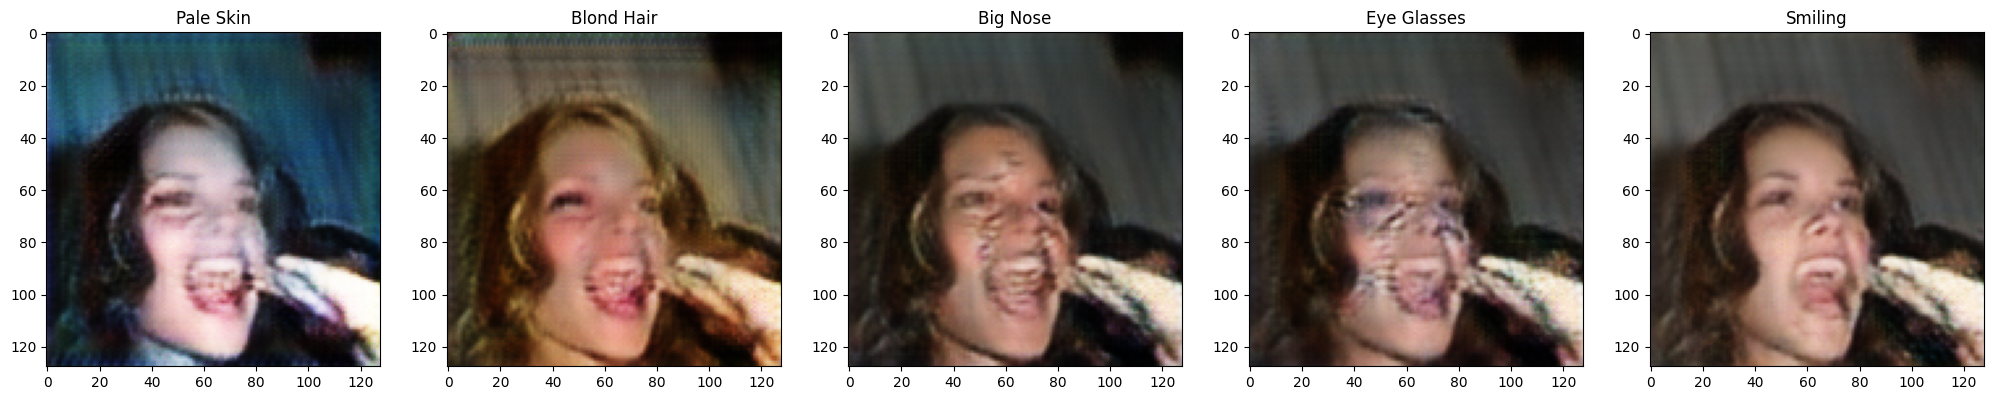

In [212]:
fig, axes = plt.subplots(1, len(x_fake_list), figsize=(5*len(x_fake_list), 5))
for i in range(len(x_fake_list)):
    axes[i].imshow(denorm(x_fake_list[i]).squeeze(0).permute(1,2,0).detach())
    axes[i].set_title(request[i])
    #axes[i].axis('off')

In [213]:
# Save the generated faces as image files
for i, (image_tensor, feature) in enumerate(zip(x_fake_list, request)):
    # Denormalize the image
    denorm_image = denorm(image_tensor).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Convert NumPy array to PyTorch tensor
    denorm_image_tensor = torch.from_numpy(denorm_image).permute(2, 0, 1).unsqueeze(0)

    # Save the image using a filename based on selected features (e.g., "generated_face_feature1_feature2.png")
    filename = f"face_generated/generated_face_{index}_{feature.replace(' ', '_')}_{i}.png"
    save_image(denorm_image_tensor, filename)

# Show the plot
plt.show()